In [31]:
# %matplotlib notebook

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import random
import math
import pickle
import datetime
from datetime import datetime

# Hyperparameters 

In [2]:
threshhold_daylight_for_classification = 800 # for trivial labeling 
data_split_seed = random.randint(0,1000000) # get a seed 
split_train_test = 0.1 #test_train split 
lightchange_threshhold = 300 # when a light jump is relevant 
NUMBER_OF_DAYS = 150 #number of possible days to get daylight points 
LIST_OF_BAD_DAYS = [1,4,6,13,64] #list of days, that have bad data, cause someone played with magnets 
PERCENTAGE_OF_UNSEEN_DAYS = 0.3 #how many days are not even in train data

# 0. Usefull functions 

In [3]:
def get_score(gold,pred, reverse=False):
    # reverse=True if the labels are switched around
    if len(gold)==len(pred):
        length = len(gold)
        count = 0
        for i in range(length):
            if gold[i]==pred[i]:
                count+=1
            else:
                count = count
        score = count/length
        if reverse:
            return (1-score) 
        else: 
            return score
    else : 
        error("Die Listen müssen die gleiche Länge haben")
    

In [4]:
def label_data_light_time_fwd(vec):
    ### vec should be day_data_withlight_withtime, returns day_y with forwardcheck###
    
    length = len(vec)
    new_day = True
    
    #initiation of the vector that contains the labels 
    fwd_y = np.zeros(length)
    
    #we start iteration at index 1, so we label fwd_y[0] manually -1
    fwd_y[0] = -1

    
    #iterate over timepoints
    for i in range(1,length):
        
        #get features for singe forward check label 
        prev_time = vec[i-1,4]
        time = vec[i,4]
        prev_light = vec[i-1,3]
        light = vec[i,3]
        prev_label = fwd_y[i-1]
    
        #test if its still a new day
        if abs(light-prev_light)>=lightchange_threshhold:
            new_day = False
        
        #test if a new day started, overwrites above
        if time-prev_time >= 1000:
            new_day = True
        
        #if its a new day,label as -1 
        if new_day:
            fwd_y[i] = -1 
        
        #else get label 0 or 1 
        else:    
            if prev_light-light >= lightchange_threshhold:
                fwd_y[i] = 1
            elif light - prev_light >= lightchange_threshhold:
                fwd_y[i] = 0 
            else: 
                fwd_y[i] = prev_label
    
    return fwd_y
            


def label_data_light_time_bwd(vec,fwd_y):
    
    length = len(fwd_y)
    label_set = False
    label = 0
    bwd_y = fwd_y
    
    #iterate backwards through fwd_y
    for i in range(length-2,-1,-1):
        
        #get features 
        next_time = vec[i+1,4]
        time = vec[i,4]
        
        #test if the day ends here
        #if yes, do nothing label-wise, but reset label_set to False
        if next_time-time >= 1000:
            label_set = False
        #else go through labels
        else:
            #if label -1 get opposite label of times before
            if bwd_y[i] == -1: 
                if label_set:
                    bwd_y[i] = label
                else: 
                    if bwd_y[i+1] == -1:
                        label = -1
                    else:
                        label = 1-bwd_y[i+1]
                    bwd_y[i] = label
                    label_set = True
    return bwd_y

def label_data_light_time_spec(vec,bwd_y):
    
    length = len(vec)
    day_y = np.copy(bwd_y)
    
    #find start indices
    #initiate vector with day_starts 
    day_starts = np.array([0])
    #find other day_starts
    for i in range(1,length):
        if vec[i,4]-vec[i-1,4] >= 1000:
            day_starts = np.append(day_starts, np.array([i]))
    
    #in order to iterate over last day wothout problems, add another index to day starts, so last day has an end
    day_starts = np.append(day_starts, np.array([length]))
    
    # go through day_starts; if a label is -1, the whole day is unlabeled and has to be labeled 
    for i in range(len(day_starts)-1):
        index = day_starts[i]
        next_index = day_starts[i+1]
        if bwd_y[index] == -1: 
            mean_of_day = np.mean(vec[index:next_index,3])
            if mean_of_day <= 600:
                label = 1
            else:
                label = 0
            for i in range (index,next_index):
                day_y[i] = label
    return day_y
    
def label_data_light_time_full(vec):
    fwd_y = label_data_light_time_fwd(vec)
    bwd_y = label_data_light_time_bwd(vec,fwd_y)
    day_y = label_data_light_time_spec(vec,bwd_y)
    return day_y



In [5]:
# used for result analysis
def get_label(tupel):
    pred = tupel[0]
    for i in range(len(pred)):
        if pred[i] >= 0.5:
            pred[i] = 1 
        else:
            pred[i] = 0
    return pred

def label_to_num(tupel):
    return np.argmax(tupel)


In [6]:

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if window_len<3:
        return x


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [7]:
def postprocessing_of_labels(labels_of_aday,window_size=4):
    
    labels_of_aday = np.array(labels_of_aday)
    length = len(labels_of_aday)
    
    #clean up single spikes
    #cleaned_labels = np.copy(labels_of_aday)
    #for i in range(1,length-1):
        #if (labels_of_aday[i-1] == labels_of_aday[i+1]) and (labels_of_aday[i] != labels_of_aday[i-1]):
            #cleaned_labels[i] = labels_of_aday[i-1]
        #else : 
            #cleaned_labels[i] = labels_of_aday[i]
        #print(i,labels_of_aday,cleaned_labels,labels_of_aday[i-1] == labels_of_aday[i+1])
    #print(cleaned_labels)
    #print(get_score(labels_of_aday,cleaned_labels))
    
    #for using parking
    postp_labels = np.copy(labels_of_aday)
    if (labels_of_aday[:window_size] == 0).all(): 
        label = 0
    elif (labels_of_aday[:window_size] == 1).all():
        label = 1 
    else:
        print('''\n CHOOSE OTHER TIMEPONT TO INITIATE POSTPROCESSING\n ''')
        return labels_of_aday
    for i in range(window_size,length):
        if (labels_of_aday[i-window_size:i] == 0).all(): 
            label = 0
        elif (labels_of_aday[i-window_size:i] == 1).all():
            label = 1 
        postp_labels[i] = label
      
    return postp_labels

In [8]:
def get_day_starts(vec):
    #vec should be day_X_withlight_withtime

    length = len(vec)
    
    #find start indices
    #initiate vector with day_starts 
    day_starts = np.array([0])
    #find other day_starts
    for i in range(1,length):
        if vec[i,4]-vec[i-1,4] >= 1000:
            day_starts = np.append(day_starts, np.array([i]))
    
    #in order to iterate over last day without problems, add another index to day starts, so last day has an end
    day_starts = np.append(day_starts, np.array([length]))
    return day_starts

In [9]:
def make_sequence (vec,seq_length=5):
    seq_vec = list()
    for i in range(seq_length-1,len(vec)):
        seq_vec.append(vec[i-(seq_length-1):i+1])
    seq_vec = np.array(seq_vec)
    return seq_vec

In [10]:
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

In [11]:
def difference(tup1,tup2):
    diff = math.sqrt(((tup1[0]-tup2[0])**2)+((tup1[1]-tup2[1])**2)+((tup1[2]-tup2[2])**2))
    return diff

In [12]:
def close_to(point,lop,dist=25):
    differences = [difference(point,lop[i]) for i in range(len(lop))]
    if (np.array(differences) <= dist).any():
        return True
    else :
        return False 

# 1. Data generation 

In [13]:
path_to_data = r"C:\Users\clhco\Projekte\SamsParkplatzMagnet\Sensorlogs.csv"
path_to_data_1 = r"C:\Users\clhco\Projekte\SamsParkplatzMagnet\sensorlogs-15-02-2020-07-04-2020.csv"

In [14]:
#get the raw data and rename columns

#load the old data
raw_data = pd.read_csv(path_to_data, sep=";")
raw_data = raw_data.rename(columns = {"UNIX_TIMESTAMP(logtime)" : "logtime"})

# load new data
raw_data_1 = pd.read_csv(path_to_data_1, sep=";")

#concat new and old data 
raw_data = pd.concat([raw_data,raw_data_1])

#rename columns
raw_data = raw_data.rename(columns = {"logtime" : "time", "ambient_light_voltage" : "light"})

In [15]:
#set the time columns as index 

data = raw_data.set_index("time")
print(data)

              x    y    z  light
time                            
1575482727  486 -586  139    503
1575482731  485 -587  139    510
1575482735  485 -587  139    474
1575482740  486 -586  139    510
1575482744  485 -587  139    506
...         ...  ...  ...    ...
1586349335  479 -538   21   1016
1586349340  478 -540   20   1016
1586349345  479 -538   21   1016
1586349350  478 -537   21   1016
1586349355  479 -538   23   1016

[2367229 rows x 4 columns]


In [16]:
#label the data 

data_labeled_with_threshhold = data.assign(label=lambda x: (x.light>threshhold_daylight_for_classification)*1)

In [17]:
#split into test and train split 

X = data_labeled_with_threshhold.iloc[:,:3].to_numpy()
y = data_labeled_with_threshhold.iloc[:,4].to_numpy()
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=split_train_test, random_state=data_split_seed)

## 1.1 Daylight points

In [18]:
#liste von Tageslichtpunkten bekommen, da nur diese gelabeled werden können

list_of_one_day = list()
list_of_daytime = list()

# Tagespunkte für einen Tag
for i in range(1575534600,1575558600):
    list_of_one_day.append(i)

# Remove bad days from Training/Test Set
list_of_days = [i for i in range(NUMBER_OF_DAYS) if i not in LIST_OF_BAD_DAYS]
#Tagespunkte für alle guten Tage 
for i in list_of_days:
    for t in list_of_one_day:
        list_of_daytime.append(t+86400*i)

day_data = data[data.index.isin(list_of_daytime)] 

In [19]:
#add time as column and convert it to array
day_data_withtime = day_data.assign(time=lambda x: x.index)
day_X_withlight_withtime = day_data_withtime.iloc[:,:5].to_numpy()

In [20]:
#get the day_starts 
day_starts = get_day_starts(day_X_withlight_withtime)

# get index from where data is unseen till testing
unseen_days_start_at = math.floor(len(day_starts)*(1-PERCENTAGE_OF_UNSEEN_DAYS))
unseen_index = day_starts[unseen_days_start_at]

In [21]:
#Split data into test and train split and get data for further data analysis

#get data into array format 
day_X = day_data_withtime.iloc[:,:3].to_numpy()

#get labels 
day_y = label_data_light_time_full(day_X_withlight_withtime)


#split into test and train set 
day_X_train, day_X_test, day_y_train, day_y_test = train_test_split( day_X[:unseen_index], day_y[:unseen_index], 
                                                                    test_size=split_train_test, 
                                                                    random_state=data_split_seed)

day_X_unseen, day_y_unseen = day_X[unseen_index:], day_y[unseen_index:]

#scaler = StandardScaler()
#scaler.fit(day_X_train)
#day_X_train = scaler.transform(day_X_train)
#day_X_test = scaler.transform(day_X_test)
#day_X_unseen = scaler.transform(day_X_unseen)

In [22]:
# also scale day_X_withlight_withtime 

#for i,x in enumerate(day_X_withlight_withtime):
#    day_X_withlight_withtime[i,:3] = scaler.transform([day_X_withlight_withtime[i,:3]])[0]

## 1.2 Take a closer look at data 

In [23]:
# take a look at the changes in the light function 

changes=np.zeros(len(day_y)-1)
for i in range(len(day_y)-1):
    changes[i]=day_X_withlight_withtime[i,3]-day_X_withlight_withtime[i+1,3]
    
sum_changes = np.zeros(401)
hist, bins = np.histogram(changes,bins=[i for i in range(40,400,1)])

for i in range (399,39,-1):
    sum_changes[i]=sum_changes[i+1]+hist[i-40-1]
#plt.plot([i for i in range(60,120)], sum_changes[60:120])

In [24]:
#Liste von Punkten, wo die Tage anfangen generieren

list_of_daystarts_oneday = list()
list_of_daystarts = list()

# Punkte wo erster Tag "anfängt"
for i in range(1575534600-5,1575534600+6):
    list_of_daystarts_oneday.append(i)
    
#Punkte wo alle Tage anfangen
for i in range(72):
    for t in list_of_daystarts_oneday:
        list_of_daystarts.append(t+86400*i)
        
daystart_data = data[data.index.isin(list_of_daystarts)]

In [25]:
#hist1 = daystart_data.hist()
#hist2 = day_data.hist()

# 2. Binary Classification using day_data

## 2.1 Logistic Regression

In [137]:
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(day_X_train, day_y_train) # ? 832 #9204
score = round(LR.score(day_X_test,day_y_test), 4)
print("The score of the Logistic Regression is: {}".format(score))

The score of the Logistic Regression is: 1.0


In [138]:
LR_score = round(LR.score(day_X_unseen, day_y_unseen), 4)
print(LR_score)

0.9261


## 2.2 SVM

In [28]:
SVM = svm.SVC(gamma='scale', C=1.0 )
SVM.fit(day_X_train, day_y_train)
score = round(SVM.score(day_X_test,day_y_test), 4)
print("The score of the SVM is: {}".format(score))

The score of the SVM is: 0.9841


In [37]:
SVM_score = round(SVM.score(day_X_unseen, day_y_unseen), 4)
print(SVM_score)

0.922


## 2.3 RandomForestClassifier

In [139]:
# RF = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0)  9009 9036 # 9861
RF = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=0)
RF.fit(day_X_train, day_y_train) 
score = round(RF.score(day_X_test,day_y_test), 4)
print("The score of the Random Forest Classfier is: {}".format(score))

The score of the Random Forest Classfier is: 1.0


In [140]:
RF_score = round(RF.score(day_X_unseen, day_y_unseen), 4)
print(RF_score)

0.9005


## 2.4 MultiLayerPerceptron (NN) 

In [141]:
# NN = MLPClassifier(hidden_layer_sizes=(20, 50, 100, 100, 50, 20), solver='adam', alpha=1e-5,  random_state=1) 0.936
# (20,50,100,100,50,20),(30,65,120,120,65,30),(10,30,70,70,30,10) max_iter =200 has  8557   8509     8612
# (10,20,30,40,50,60,70,70,60,50,40,30,20,10), (100,90,80,70,60,50,40,30,20,10)  8553 8429
# NN_to_test = [(10,30,70,70,30,10),(5,20,55,55,20,5),(20,45,90,90,45,20)] 9279, 9346, 9387
# NN_to_test = [(20,30,45,65,90,90,65,45,30,20),(30,60,120,120,60,30)] 9290 9306
# (20,45,90,90,45,20) 9505 # 9918
# (30,55,110,110,55,30) # 9918
# (40,65,130,130,65,40) 9932
# (10,10,20,20,20,20,10,10) 9996
NN_to_test = [(10,10,20,20,20,20,10,10)]
for i in range(len(NN_to_test)):
    NN = MLPClassifier(hidden_layer_sizes=NN_to_test[i], solver='adam', alpha=1e-5,  random_state=1, max_iter=250)
    NN.fit(day_X_train, day_y_train)
    score = round(NN.score(day_X_test,day_y_test), 4)
    print("The score of the MLP is: {}".format(score))

The score of the MLP is: 1.0


In [142]:
NN_score = round(NN.score(day_X_unseen, day_y_unseen), 4)
print(NN_score) 

#(10,10,20,20,20,20,20,20,10,10) 9996, 9378 
#(10,10,20,20,20,20,10,10) 9981 9725
# #(10,10,20,20,20,20,10,10) ? 9427

0.9235


# 2.5 Save and Load the Models

In [35]:
output = r"C:\Users\clhco\Projekte\SamsParkplatzMagnet\LR.pkl"
with open(output,"wb") as dumphere:
    pickle.dump(LR,dumphere)
    
output = r"C:\Users\clhco\Projekte\SamsParkplatzMagnet\SVM.pkl"
with open(output,"wb") as dumphere:
    pickle.dump(SVM,dumphere)

output = r"C:\Users\clhco\Projekte\SamsParkplatzMagnet\RF.pkl"
with open(output,"wb") as dumphere:
    pickle.dump(RF,dumphere)
    
output = r"C:\Users\clhco\Projekte\SamsParkplatzMagnet\NN.pkl"
with open(output,"wb") as dumphere:
    pickle.dump(NN,dumphere)

In [36]:
output = r"C:\Users\clhco\Projekte\SamsParkplatzMagnet\NN.pkl"
NN = pickle.load(open( output, "rb" ))
output = r"C:\Users\clhco\Projekte\SamsParkplatzMagnet\RF.pkl"
RF = pickle.load(open( output, "rb" ))
output = r"C:\Users\clhco\Projekte\SamsParkplatzMagnet\SVM.pkl"
SVM = pickle.load(open( output, "rb" ))
output = r"C:\Users\clhco\Projekte\SamsParkplatzMagnet\LR.pkl"
LR = pickle.load(open( output, "rb" ))

# 3. Clustering using non labeled data 

## 3.1 KMeans 

In [29]:
kmeans_est = KMeans(n_clusters=2, max_iter=5, n_init=1)
kmeans_est.fit(day_X_train)
labels = kmeans_est.labels_ 
score = round(get_score(kmeans_est.predict(day_X_unseen),day_y_unseen),4)

# since clustering does not know my classes, it might give them the wrong labels, so i have to get the "right" score
if score>= 0.5:
    score = score 
else: 
    score = 1 - score
    
print("The score of K-Means is: {}".format(score))

The score of K-Means is: 0.9567


<IPython.core.display.Javascript object>


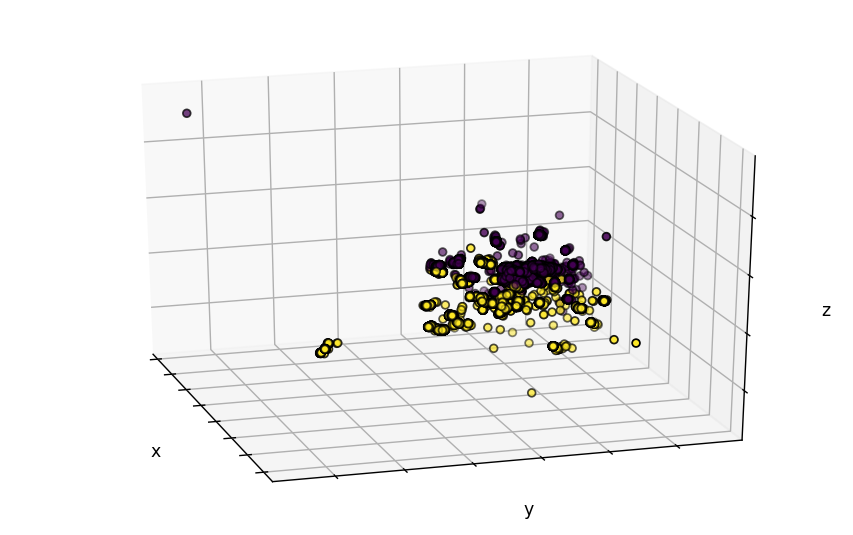

Text(0.5, 0, 'z')

In [30]:
## draw the clustered training points with their labels 

name = 'Cluster Daten'

fig = plt.figure()

ax = Axes3D(fig)    
ax.scatter(day_X_train[:, 0], day_X_train[:, 1], day_X_train[:, 2], c=labels.astype(np.float), edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

#fig.show()

# 4. Classification using Sequential Data

## 4.1 Generation of Sequential Data 

In [160]:
SEQUENCE_LENGTH = 5

seq_X_day_test = list()
seq_y_day_test = list()
seq_X_day_train = list()
seq_y_day_train = list()
seq_light_day_train = list()
seq_light_day_test = list()

random.seed(234250982)
train_and_test = [i for i in range(len(day_starts)-1)]
random.shuffle(train_and_test)

counter = 0
i = SEQUENCE_LENGTH-1
while i < len(day_y)/2:
    if day_X_withlight_withtime[i,4]-day_X_withlight_withtime[i-(SEQUENCE_LENGTH-1),4] < 200:
        if counter in train_and_test[:50]:
            seq_X_day_train.append([x  for y in day_X_withlight_withtime[i-(SEQUENCE_LENGTH-1):i+1,:3] for x in y ])
            seq_y_day_train.append(day_y[i])
            seq_light_day_train.append(day_X_withlight_withtime[i,3])
        else: 
            seq_X_day_test.append([x for y in day_X_withlight_withtime[i-(SEQUENCE_LENGTH-1):i+1,:3] for x in y ])
            seq_y_day_test.append(day_y[i])
            seq_light_day_test.append(day_X_withlight_withtime[i,3])
        i += 1
    else:
        counter += 1
        i += (SEQUENCE_LENGTH-1)
 


seq_X_day_test = np.array(seq_X_day_test)
seq_y_day_test = np.array(seq_y_day_test)
seq_X_day_train = np.array(seq_X_day_train)
seq_y_day_train = np.array(seq_y_day_train)

scaler_seq = StandardScaler()
scaler_seq = scaler.fit(seq_X_day_train)
seq_X_day_train = scaler.transform(seq_X_day_train)
seq_X_day_test = scaler.transform(seq_X_day_test)

## 4.2 Logistic Regression 

In [161]:
LR_seq = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr', max_iter=200) # 7323
LR_seq.fit(seq_X_day_train, seq_y_day_train)
score = round(LR_seq.score(seq_X_day_test, seq_y_day_test), 4)
print("The score of the Logistic Regression sequentual is: {}".format(score))

The score of the Logistic Regression sequentual is: 0.7885


## 4.3 SVM 

In [162]:
SVM_seq = svm.SVC(gamma='scale', C=1.0 , max_iter = 10000) # 
SVM_seq.fit(seq_X_day_train, seq_y_day_train)
score = round(SVM_seq.score(seq_X_day_test, seq_y_day_test), 4)
print("The score of the SVM sequential is: {}".format(score))

C:\Users\clhco\Anaconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


The score of the SVM sequential is: 0.2115


## 4.4 Random Forest Classifier

In [163]:
RF_seq = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=0) #8228
RF_seq.fit(seq_X_day_train, seq_y_day_train) 
score = round(RF_seq.score(seq_X_day_test, seq_y_day_test), 4)
print("The score of the Random Forest Classfier sequential is: {}".format(score))

The score of the Random Forest Classfier sequential is: 0.7885


## 4.5 Neural Network 

In [164]:
# NN_to_test = [(50,80,100,150,100,70,20),(20,50,100,60,30),(50,150,300,100,20)] 0.866 ...
# NN_to_test = [(50,100,150,300,150,100,5 0,20)]
# (50,80,100,100,70,50)
# (10,20,20,20,20,20,10) 9638
NN_to_test = [(10,20,20,20,20,20,20,20,20,10)] #8613
for i in range(len(NN_to_test)):
    NN_seq = MLPClassifier(hidden_layer_sizes=NN_to_test[i], solver='adam', alpha=1e-5,  random_state=1, max_iter=250)
    NN_seq.fit(seq_X_day_train, seq_y_day_train)
    score = round(NN_seq.score(seq_X_day_test, seq_y_day_test), 4)
    print("The score of the NN sequential is: {}".format(score))

The score of the NN sequential is: 0.7885


# 4.6 Save and load the models

In [165]:
output = r"C:\Users\clhco\Projekte\SamsParkplatzMagnet\LR_seq.pkl"
with open(output,"wb") as dumphere:
    pickle.dump(LR_seq,dumphere)
    
output = r"C:\Users\clhco\Projekte\SamsParkplatzMagnet\SVM_seq.pkl"
with open(output,"wb") as dumphere:
    pickle.dump(SVM_seq,dumphere)

output = r"C:\Users\clhco\Projekte\SamsParkplatzMagnet\RF_seq.pkl"
with open(output,"wb") as dumphere:
    pickle.dump(RF_seq,dumphere)
    
output = r"C:\Users\clhco\Projekte\SamsParkplatzMagnet\NN_seq.pkl"
with open(output,"wb") as dumphere:
    pickle.dump(NN_seq,dumphere)

In [25]:
output = r"C:\Users\clhco\Projekte\SamsParkplatzMagnet\LR_seq.pkl"
LR_seq = pickle.load(open( output, "rb" ))
output = r"C:\Users\clhco\Projekte\SamsParkplatzMagnet\SVM_seq.pkl"
SVM_seq = pickle.load(open( output, "rb" ))
output = r"C:\Users\clhco\Projekte\SamsParkplatzMagnet\RF_seq.pkl"
RF_seq = pickle.load(open( output, "rb" ))
output = r"C:\Users\clhco\Projekte\SamsParkplatzMagnet\NN_seq.pkl"
NN_seq = pickle.load(open( output, "rb" ))

## 4.6 Error Analysis of Sequential Data Models 

In [410]:
diam = 12
radius = 6
#for i, row in enumerate(day_X): 
#    if day_y_new[i]!=day_y_new[i-1]:
#        print(".........")
#        for j in range(diam):
#            print(day_y_new[i-radius+j],day_X_withlight_withtime[i-radius+j,:3],day_X_withlight_withtime[i-radius+j,3],
#                 day_X_withlight_withtime[i-radius+j,4])

# 5. Classification with RNN using keras 

In [60]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, TimeDistributed, SimpleRNN
from keras.utils import to_categorical

Using TensorFlow backend.


## 5.1 Getting Data into Format

In [152]:
# get data into format
rnn_X_day_test = list()
rnn_y_day_test = list()
rnn_X_day_train = list()
rnn_y_day_train = list()
rnn_light_day_train = list()
rnn_light_day_test = list()

random.seed(200537987)
train_and_test = [i for i in range (0,len(day_starts))]
# random.shuffle(train_and_test)

counter = 0
i = 4 

while i < len(day_y):
    if day_X_withlight_withtime[i,4]-day_X_withlight_withtime[i-4,4] < 200:
        if counter in train_and_test[:unseen_days_start_at]:
            rnn_X_day_train.append(day_X_withlight_withtime[i-4:i+1,:3])
            rnn_y_day_train.append(day_y[i])
            rnn_light_day_train.append(day_X_withlight_withtime[i,3])
        else: 
            rnn_X_day_test.append(day_X_withlight_withtime[i-4:i+1,:3])
            rnn_y_day_test.append(day_y[i])     
            rnn_light_day_test.append(day_X_withlight_withtime[i,3])
        i += 1
    else:
        counter += 1
        i += 4



rnn_X_day_train = np.array(rnn_X_day_train)
rnn_y_day_train = np.array(rnn_y_day_train)
rnn_X_day_test = np.array(rnn_X_day_test)
rnn_y_day_test = np.array(rnn_y_day_test)
rnn_y_day_train = to_categorical(rnn_y_day_train)
rnn_y_day_test = to_categorical(rnn_y_day_test)

## 5.2 Generating RNN Model

In [153]:
model = Sequential()
model.add(SimpleRNN(30,input_shape=(5,3)))
model.add(Dropout(0.5))
model.add(Dense(20, activation = 'tanh'))
model.add(Dropout(0.5))
model.add(Dense(20, activation = 'tanh'))
model.add(Dropout(0.5))
model.add(Dense(20, activation = 'tanh'))
model.add(Dropout(0.5))
model.add(Dense(20, activation = 'tanh'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'tanh'))
model.add(Dropout(0.5))
model.add(Dense(2,activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy' , optimizer = 'adadelta', metrics=['accuracy'])

# 200, 150, 100, 50, 9940 9339

## 5.3 Train the Model

In [154]:
model.fit(rnn_X_day_train, rnn_y_day_train,batch_size=25, epochs=5, verbose=1 )

_, RNN_score = model.evaluate(rnn_X_day_test, rnn_y_day_test, verbose=0)
RNN_score = round(RNN_score,4)
print(RNN_score) 

Epoch 1/5
453842/453842 [==============================] - 52s 114us/step - loss: 0.5804 - accuracy: 0.7346
Epoch 2/5
453842/453842 [==============================] - 50s 111us/step - loss: 0.5770 - accuracy: 0.7366
Epoch 3/5
453842/453842 [==============================] - 50s 111us/step - loss: 0.5769 - accuracy: 0.7366
Epoch 4/5
453842/453842 [==============================] - 51s 113us/step - loss: 0.5769 - accuracy: 0.7366
Epoch 5/5
453842/453842 [==============================] - 52s 116us/step - loss: 0.5769 - accuracy: 0.7366
0.8808


# 5.4 Save and Load the models 

In [155]:
output = r"C:\Users\clhco\Projekte\SamsParkplatzMagnet\RNN.pkl"
with open(output,"wb") as dumphere:
    pickle.dump(RNN,dumphere)

NameError: name 'RNN' is not defined

## 5.5 Error Analysis of RNN Model


In [411]:
#print('Sequence, prediction, light, truth')
#for i,seq in enumerate(rnn_X_day_test):
#    if (get_label(model.predict(np.array([seq]))) != rnn_y_day_test[i]).all():
#        print(seq,label_to_num(get_label(model.predict(np.array([seq])))),
#              rnn_light_day_test[i-4:i+1],label_to_num(rnn_y_day_test[i]))

In [312]:
count=np.array([0,0])
for i,seq in enumerate(rnn_X_day_test):
    if label_to_num(get_label(model.predict(np.array([seq]))))==0: 
        count[0] += 1 
    else:
        count[1] += 1
print(count)

[98148 45837]


# 6. Error Analysis using graphs

## 6.1 Plotting time, label and prediction 

100
SVM
0.9998
1.0


<IPython.core.display.Javascript object>


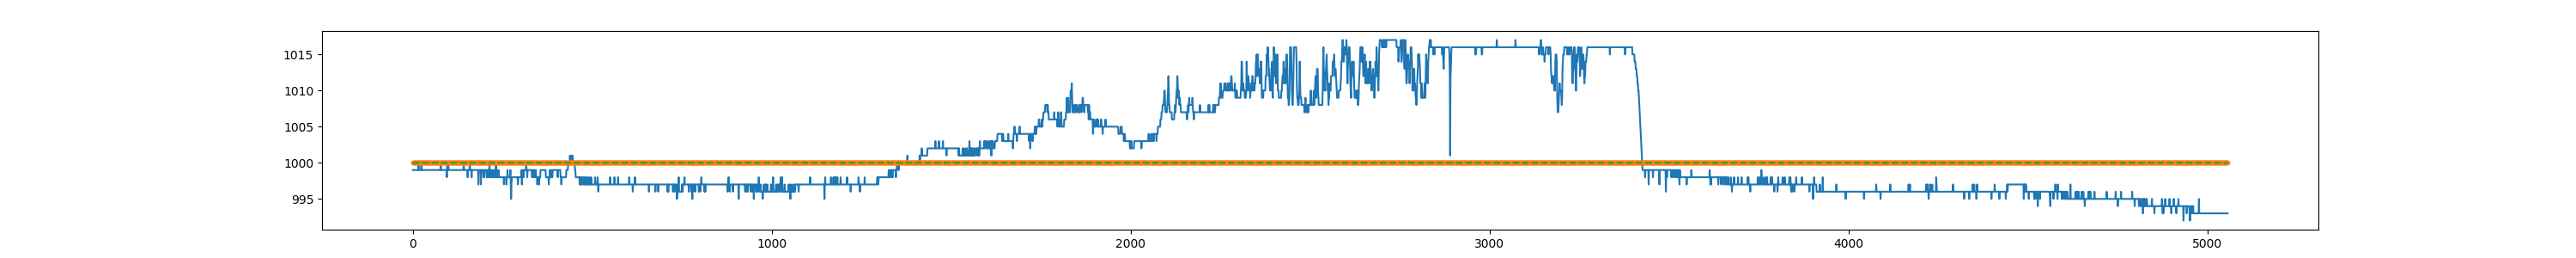

101
SVM
1.0
1.0


<IPython.core.display.Javascript object>


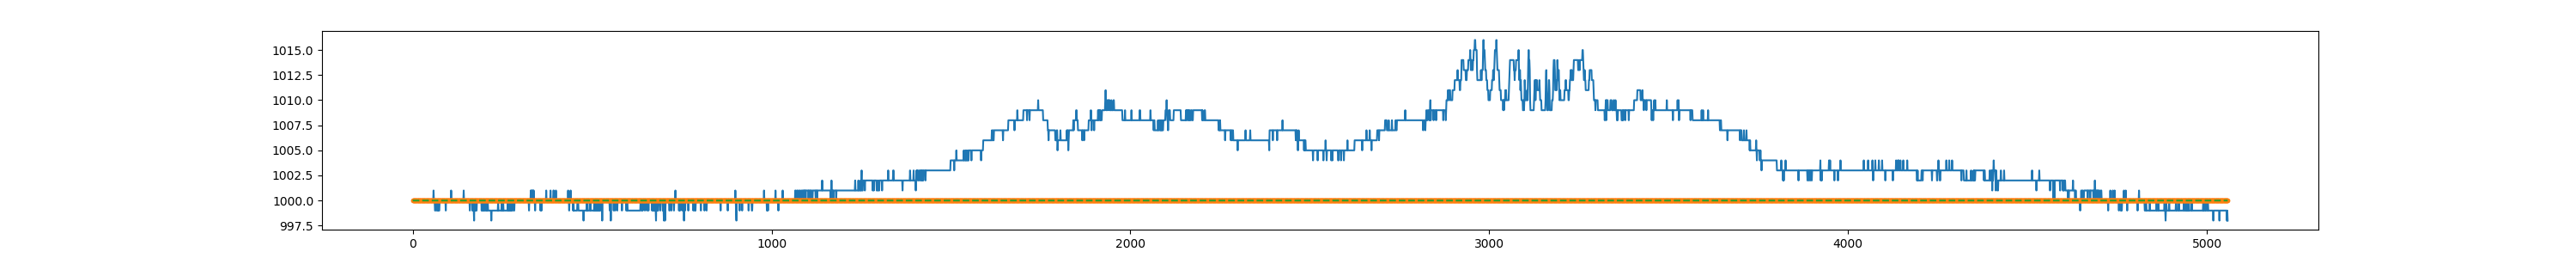

102
SVM
1.0
1.0


<IPython.core.display.Javascript object>


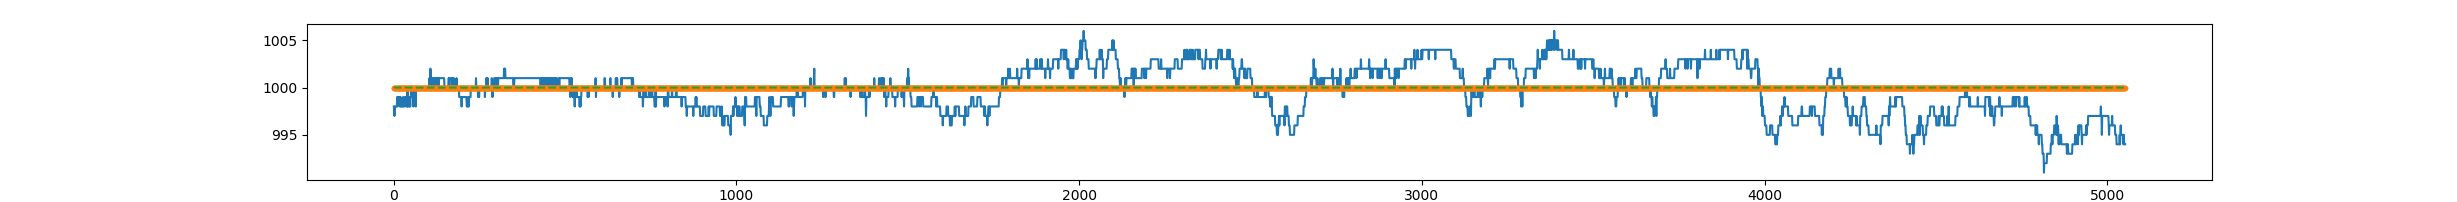

103
SVM
1.0
1.0


<IPython.core.display.Javascript object>


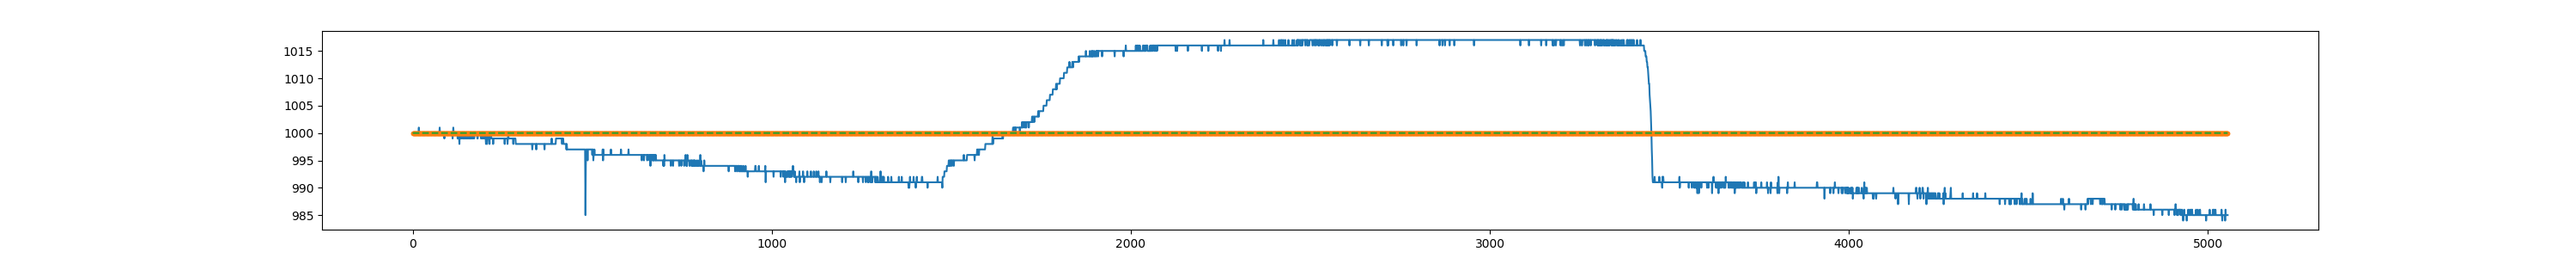

104
SVM
1.0
1.0


<IPython.core.display.Javascript object>


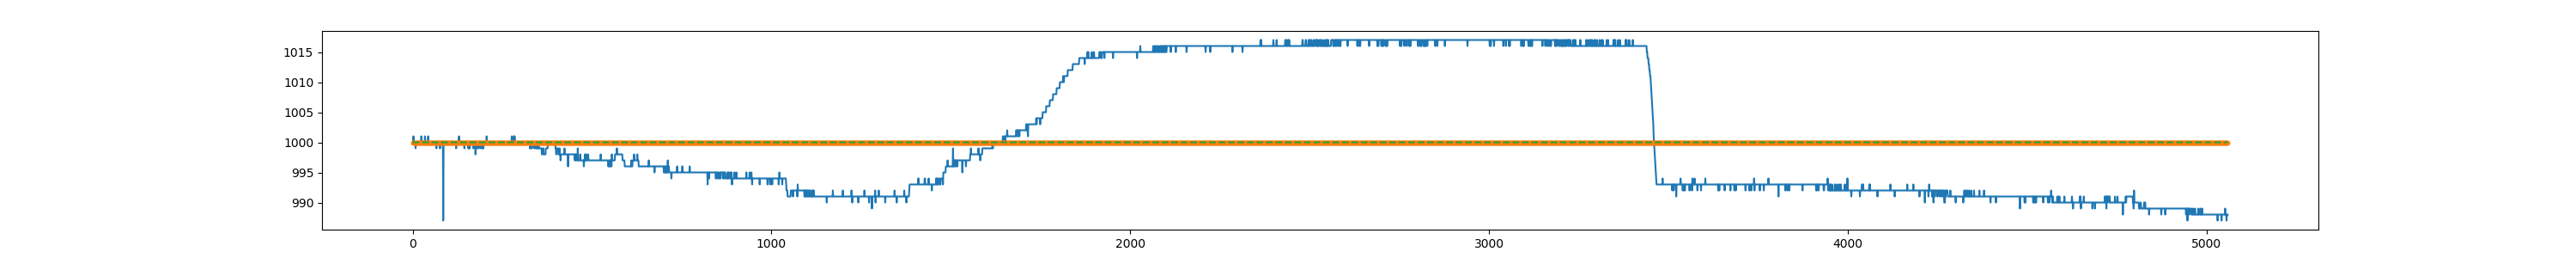

105
SVM
1.0
1.0


<IPython.core.display.Javascript object>


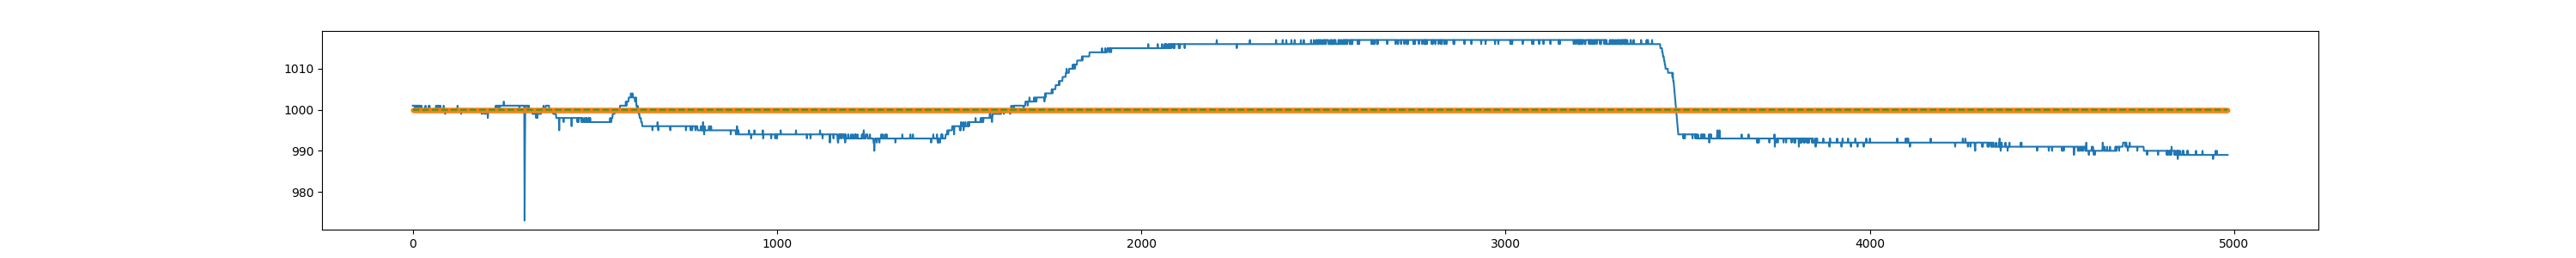

106
SVM
1.0
1.0


<IPython.core.display.Javascript object>


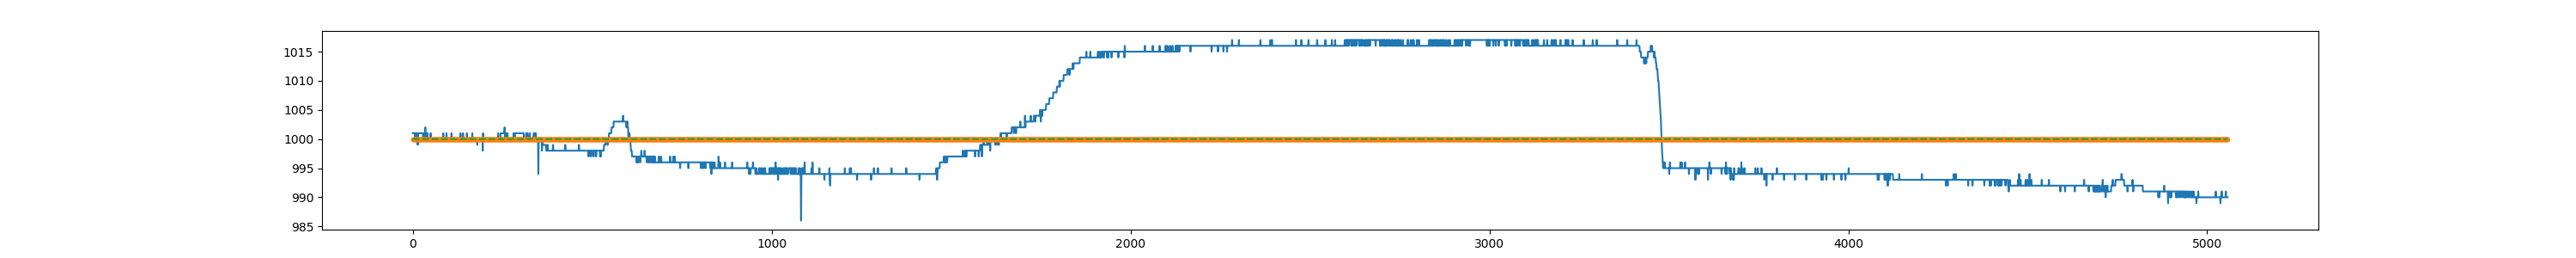

107
SVM
1.0
1.0


<IPython.core.display.Javascript object>


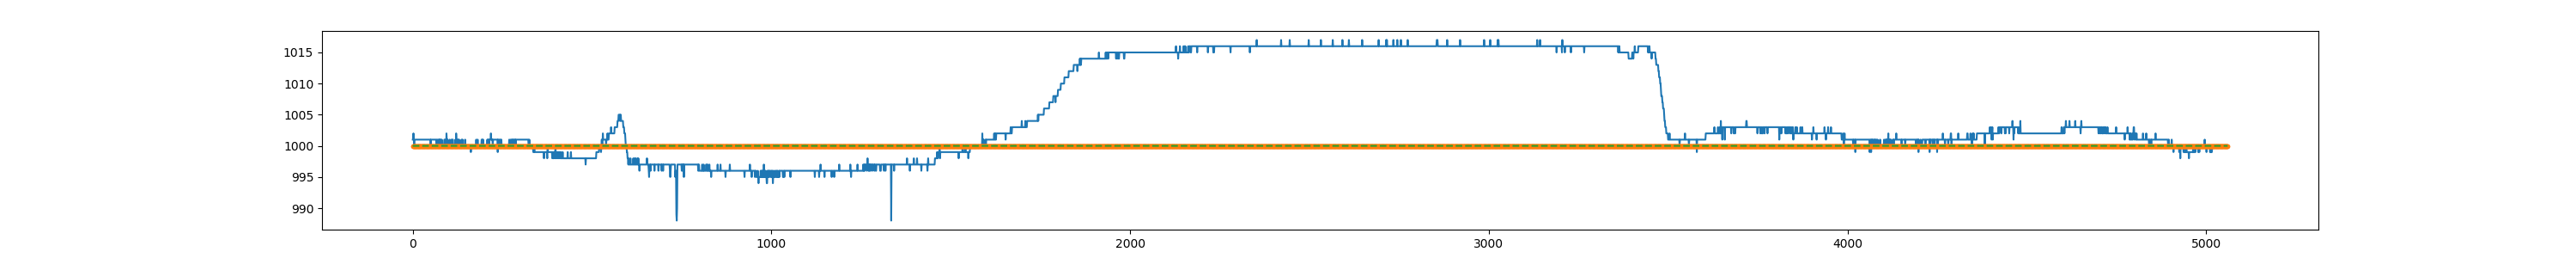

108
SVM
0.9966
0.996


<IPython.core.display.Javascript object>


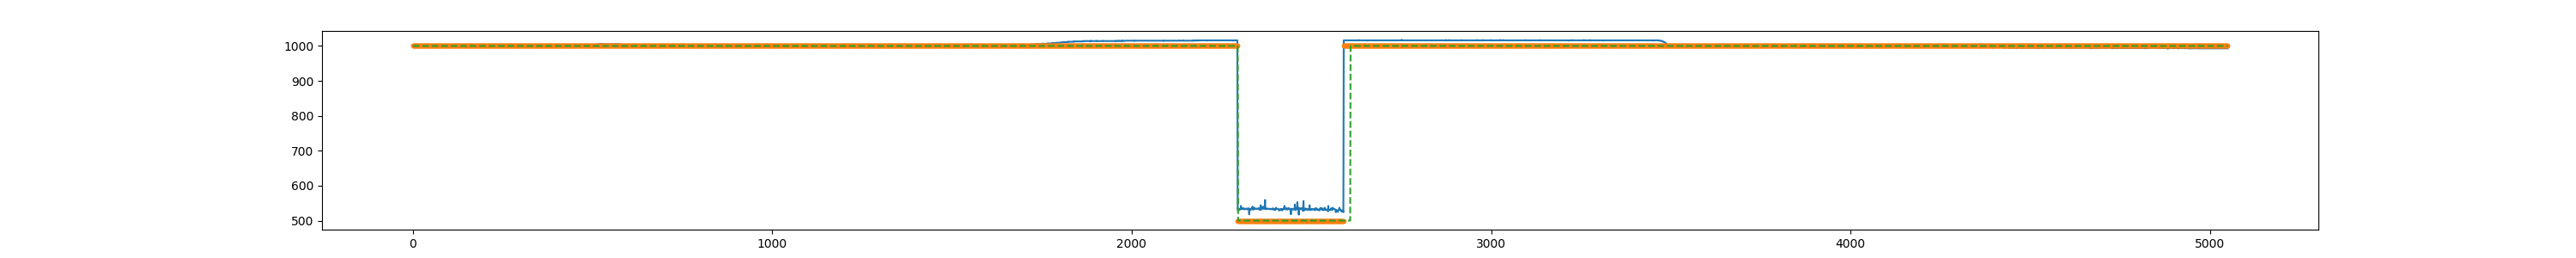

109
SVM
1.0
1.0


<IPython.core.display.Javascript object>


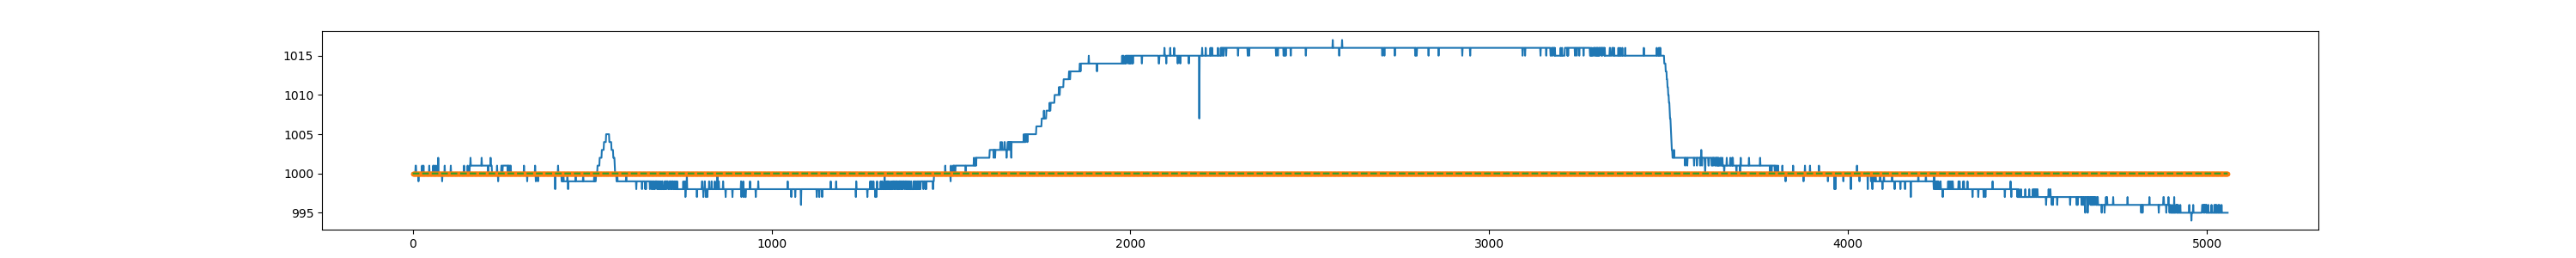

In [34]:
SHOW_MAGNETS = False
HEIGHT_OF_GRAPHS = 3
CLASSIFIERS_TO_EVAL = ['SVM']
vec = day_X_withlight_withtime

for i in range(100,110):
    
    print(i)
    labels = [(2-label)*500 for label in day_y[day_starts[i]:day_starts[i+1]]]
    
    for classifier in CLASSIFIERS_TO_EVAL:
        
        if classifier == 'model':
            
            predicted_labels = [np.argmax(tup)
                                for tup in eval(classifier+'.predict(make_sequence(vec[day_starts[i]:day_starts[i+1],:3]))')]
            score = round(get_score(predicted_labels,day_y[day_starts[i]+4:day_starts[i+1]]),4)
            predicted_labels = postprocessing_of_labels(predicted_labels)
            score_p = round(get_score(predicted_labels,day_y[day_starts[i]+4:day_starts[i+1]]),4)
            predicted_labels = [(2-label)*500 for label in predicted_labels]

            print('RNN')
            print(score)
            print(score_p)
    
            plt.figure(figsize=(30, HEIGHT_OF_GRAPHS), dpi=80)
            plt.plot(vec[day_starts[i]+5:day_starts[i+1],3])
            plt.plot(labels,'.')
            plt.plot(predicted_labels,'--')
            plt.show(block=False)
            
        elif classifier.endswith('_seq'):
            
            predicted_labels = eval(classifier+'''.predict(
            scaler_seq.transform([ seq.flatten() for seq in make_sequence(vec[day_starts[i]:day_starts[i+1],:3])]))''')
            score = round(get_score(predicted_labels,day_y[day_starts[i]+4:day_starts[i+1]]),4)
            predicted_labels = postprocessing_of_labels(predicted_labels)
            score_p = round(get_score(predicted_labels,day_y[day_starts[i]+4:day_starts[i+1]]),4)
            predicted_labels = [(2-label)*500 for label in predicted_labels]

            print(classifier)
            print(score)
            print(score_p)
    
            plt.figure(figsize=(30, HEIGHT_OF_GRAPHS), dpi=80)
            plt.plot(vec[day_starts[i]+5:day_starts[i+1],3])
            plt.plot(labels,'.')
            plt.plot(predicted_labels,'--')
            plt.show(block=False)
            
            
        else:
            

            vec[day_starts[i]:day_starts[i+1],:3]
            predicted_labels = eval(classifier+'.predict(vec[day_starts[i]:day_starts[i+1],:3])')
            score = round(get_score(predicted_labels,day_y[day_starts[i]:day_starts[i+1]]),4)
            predicted_labels = postprocessing_of_labels(predicted_labels)
            score_p = round(get_score(predicted_labels,day_y[day_starts[i]:day_starts[i+1]]),4)
            predicted_labels = [(2-label)*500 for label in predicted_labels]

            print(classifier)
            print(score)
            print(score_p)
    
            plt.figure(figsize=(30, HEIGHT_OF_GRAPHS), dpi=80)
            plt.plot(vec[day_starts[i]:day_starts[i+1],3])
            plt.plot(labels,'.')
            plt.plot(predicted_labels,'--')
            plt.show(block=False)
        
        
            
 
    
    if SHOW_MAGNETS: 

        print('x')
        plt.figure(figsize=(30, HEIGHT_OF_GRAPHS), dpi=80)
        plt.plot(vec[day_starts[i]:day_starts[i+1],0])
        plt.show(block=False)
        print('y')
        plt.figure(figsize=(30, HEIGHT_OF_GRAPHS), dpi=80)
        plt.plot(vec[day_starts[i]:day_starts[i+1],1])
        plt.show(block=False)
        print('z')
        plt.figure(figsize=(30, HEIGHT_OF_GRAPHS), dpi=80)
        plt.plot(vec[day_starts[i]:day_starts[i+1],2])
        plt.show(block=False)

    

# Fehler : 
# wegen früher Dunkelheit spike nach oben nicht gemerkt: 4, 6,
# noise ruckler(kurzes hin und her) : 1, 13, 68 
# daher werden 1,4,6,13, 64 aus dem Datensatz entfernt aufgrund von artfakten der magnetspule,
#        die durch licht nicht erkannt werden

# print(day_starts[100]) = 524044

## 6.2 Plot the distribution of the classifiers 

In [31]:
#find out the intervalls the values are in 

vec = day_X_withlight_withtime

x_max = vec[:,0].max()
x_min = vec[:,0].min()
y_max = vec[:,1].max()
y_min = vec[:,1].min()
z_max = vec[:,2].max()
z_min = vec[:,2].min()

# print(x_max,x_min,y_max,y_min,z_max,z_min) 1073 64 -318 -1375 1162 -1343

In [82]:
# get the points in the dataset with their labels 
vec = day_X_withlight_withtime

points_to_paint_0 = list()
points_to_paint_1 = list()

for i,ts in enumerate(vec):
    if day_y[i] == 0:
        xyz=[roundup(x) for x in ts[:3]]
        if xyz not in points_to_paint_0:
            points_to_paint_0.append(xyz)
    else: 
        xyz=[roundup(x) for x in ts[:3]]
        if xyz not in points_to_paint_1:
            points_to_paint_1.append(xyz)  
    
list_of_times = list()
for i,tx in enumerate(vec):
    xyz = [roundup(x) for x in ts[:3]]
    if close_to(xyz,points_to_paint_0,dist=0):
        list_of_times.append(ts[4])


In [84]:
print(len(list_of_times))


627218


In [87]:
list_of_right_times = [datetime.fromtimestamp(list_of_times[i]) for i in range(len(list_of_times))]
print(list_of_right_times)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
list_of_right_times = sorted(list_of_right_times)
print(list_of_right_times)

In [33]:
print(len(points_to_paint_0),len(points_to_paint_1))

759 803


<IPython.core.display.Javascript object>


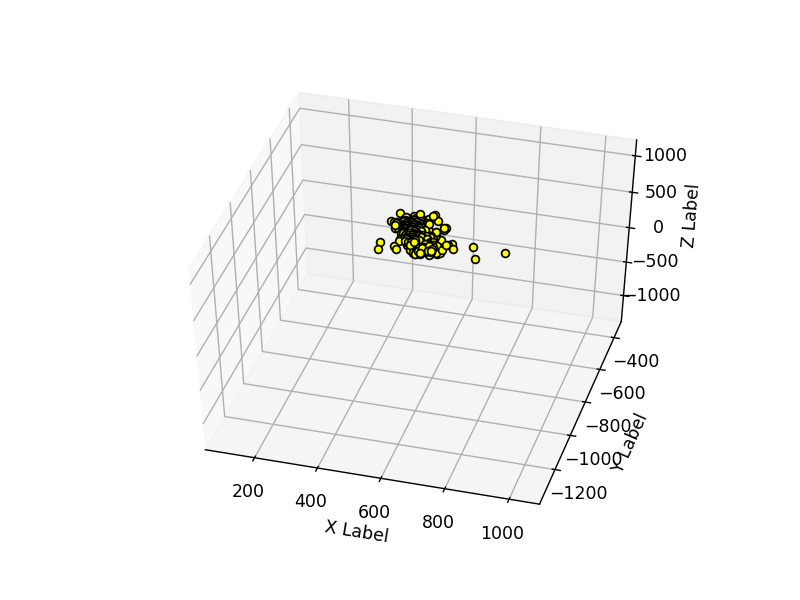

<IPython.core.display.Javascript object>


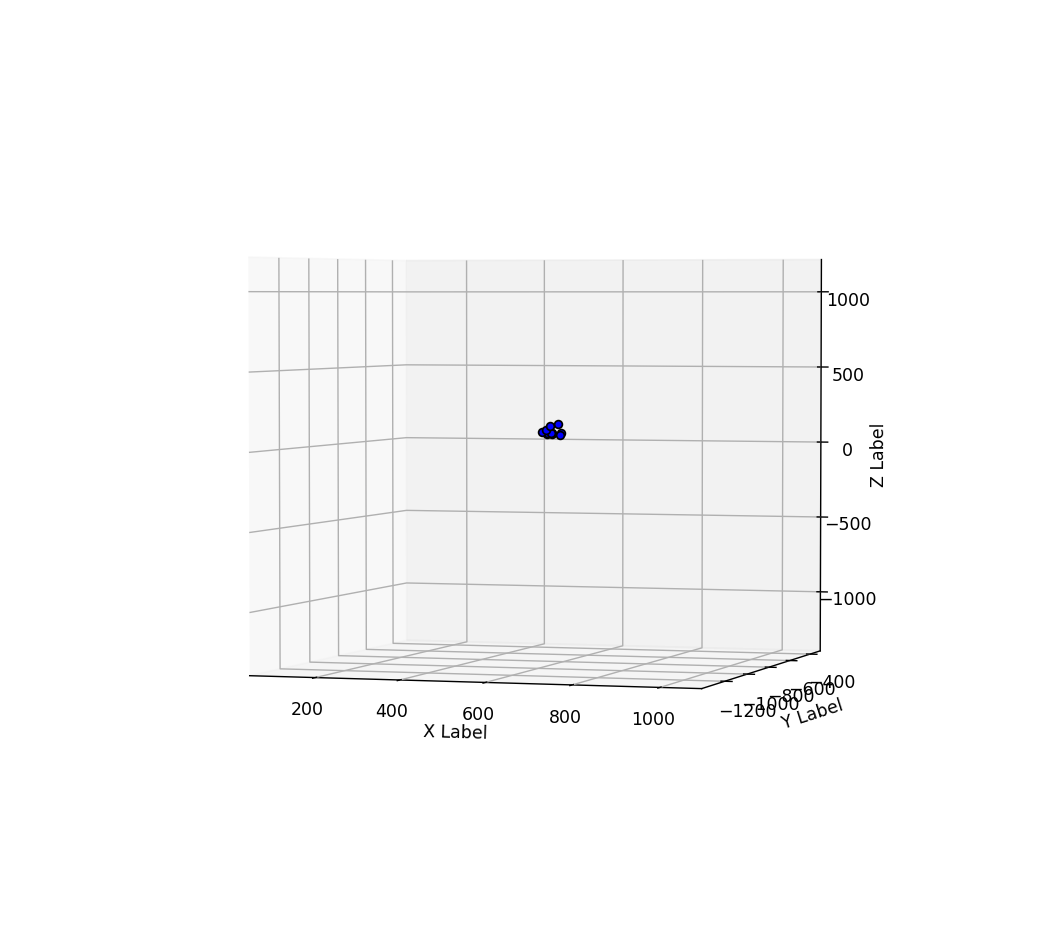

[540, -640, 130]
[510, -640, 90]
[500, -640, 80]
[520, -640, 120]
[510, -600, 70]
[510, -590, 70]
[500, -600, 60]
[500, -600, 70]
[510, -590, 60]
[540, -620, 70]
[540, -630, 60]


In [74]:
#plot the points in the dataset with their label
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for point in points_to_paint_0:
    xs = point[0]
    ys = point[1]
    zs = point[2]
    ax.scatter(xs, ys, zs, s=20, color='yellow', edgecolor='k')


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)
ax.set_zlim(z_min,z_max)

plt.show(block=False)




fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
    
for point in points_to_paint_1:
    if close_to(point,points_to_paint_0, dist=0):
        xs = point[0]
        ys = point[1]
        zs = point[2]
        ax.scatter(xs, ys, zs, s=20, color='blue', edgecolor='k')
        print(point)
        
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_xlim(x_min,x_max)
ax.set_ylim(y_min,y_max)
ax.set_zlim(z_min,z_max)

plt.show(block=False)

In [180]:
#get the points and label them 

PLOT_TRUTH = True

for classifier in ['LR','SVM','RF','NN']:
    
    print(classifier)
    
    points = list()

    for x in range(x_min,x_max):
        for y in range(y_min,y_max):
            for z in range(z_min,z_max):
                points.append([x,y,z])

    predict_0 = list() 
    predict_1 = list()
    for point in points:
        lable_1 = eval(classifier+'.predict([point])[0]')
        if lable_1 == 0:
            predict_0.append(point)
        else:
            predict_1.append(point)
    print(predict_0[0],predict_0[-1])
    #plot the points

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    colors=['blue','yellow']
    for label,labeled_vec in enumerate([predict_0]):
        for vector in labeled_vec:
            xs = vector[0]
            ys = vector[1]
            zs = vector[2]
            color = colors[label]
            ax.scatter(xs, ys, zs, s=20,c=color,edgecolor = 'k')
    
    if PLOT_TRUTH:
        for point in points_to_paint:
            xs = point[0]
            ys = point[1]
            zs = point[2]
            ax.scatter(xs, ys, zs, s=20, color='yellow',edgecolor = 'k')
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim(x_min,x_max)
    ax.set_ylim(y_min,y_max)
    ax.set_zlim(z_min,z_max)

    plt.show(block=False)

LR


IndexError: list index out of range

In [ ]:
print("The score of the Logistic Regression on unseen data is : {}".format(RF_score))
print("The score of the Support Vector Machine on unseen data is: {}".format(SVM_score))
print("The score of the Random Forst Classifier on unseen data is: {}".format(RF_score))
print("The score of the Neural Network on unseen data is: {}".format(NN_score))
print("The score of the RNN on unseen data is: {}".format(RNN_score))

In [10]:
for i in range(0): 
    plt.figure(figsize=(30, 10), dpi=80)
    plt.plot(smooth(day_X_withlight_withtime[day_starts[i]:day_starts[i+1],3],window_len = 10000))
    plt.plot(day_X_withlight_withtime[day_starts[i]:day_starts[i+1],3])
    plt.show(block=False)